# Fruits classification


In [ ]:
!unzip "/content/Fruits_Dataset.zip"

### Importing Libraries


In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report


In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Function to remove previously augmented images
def remove_augmented_images(directory):
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.startswith("augmented_"):
                os.remove(os.path.join(root, filename))

# Function to perform data augmentation on images in a directory
def augment_images_in_directory(directory, target_count):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']  # Add more extensions if needed
    images_per_class = {}

    # Remove previously augmented images
    remove_augmented_images(directory)

    # Count images per class
    for root, dirs, files in os.walk(directory):
        image_count = 0
        for filename in files:
            _, ext = os.path.splitext(filename)
            if ext.lower() in image_extensions:
                image_count += 1
        images_per_class[root] = image_count

    # Find the maximum image count
    max_count = max(images_per_class.values())

    # Augment images to achieve target count
    for root, dirs, files in tqdm(os.walk(directory), desc="Augmenting images"):
        for filename in files:
            _, ext = os.path.splitext(filename)
            if ext.lower() in image_extensions:
                img_path = os.path.join(root, filename)
                img = cv2.imread(img_path)

                # Apply augmentation until target count is reached
                while images_per_class[root] < target_count:
                    # Random rotation
                    angle = np.random.randint(-15, 16)  # Rotation angle in degrees
                    rows, cols, _ = img.shape
                    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
                    augmented_img = cv2.warpAffine(img, M, (cols, rows))

                    # Random brightness adjustment
                    brightness_factor = np.random.uniform(0.7, 1.3)  # Random brightness factor
                    augmented_img = np.clip(augmented_img * brightness_factor, 0, 255).astype(np.uint8)

                    # Random Gaussian blur
                    if np.random.rand() < 0.5:  # Apply blur with 50% probability
                        augmented_img = cv2.GaussianBlur(augmented_img, (5, 5), 0)

                    # Save the augmented image
                    new_filename = f"augmented_{images_per_class[root]}_{filename}"
                    new_img_path = os.path.join(root, new_filename)
                    cv2.imwrite(new_img_path, augmented_img)

                    images_per_class[root] += 1

# Example usage
input_directory = "/content/Fruits_Dataset"
target_count_per_class = 500  # Set your desired target count per class
augment_images_in_directory(input_directory, target_count_per_class)


Augmenting images: 7it [00:24,  3.50s/it]


### Loading and Preprocessing Data


In [3]:
def load_images_and_labels(dataset_dir):
    data = []
    labels = []
    for root, _, files in os.walk(dataset_dir):
        label = os.path.basename(root)
        for file in files:
            with Image.open(os.path.join(root, file)) as img:
                img_resized = img.resize((64, 64)).convert('L')
                img_array = np.array(img_resized).flatten()
                data.append(img_array)
                labels.append(label)
    combined = list(zip(data, labels))
    random.shuffle(combined)
    data[:], labels[:] = zip(*combined)

    return data, labels

dataset_dir = "/content/Fruits_Dataset"
data, labels = load_images_and_labels(dataset_dir)

In [4]:
def normalize_data(data):
    data = np.array(data)
    max_val = np.max(data)
    min_val = np.min(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

data = normalize_data(data)
print("Normalized data shape:", data.shape)

Normalized data shape: (3000, 4096)


### Visualizing Data


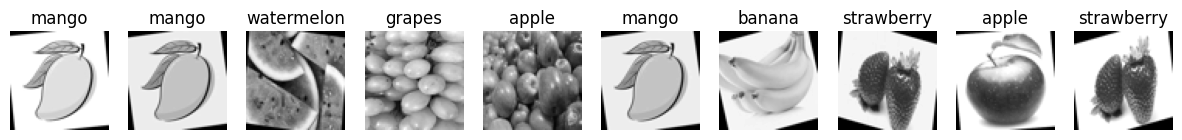

In [5]:
def visualize_data(data, labels, num_images=10):
    random_indices = np.random.choice(len(data), num_images, replace=False)
    plt.figure(figsize=(15, 3))
    for i, index in enumerate(random_indices):
        plt.subplot(1, num_images, i+1)
        img = data[index].reshape(64, 64)
        plt.imshow(img, cmap='gray')
        plt.title(labels[index])
        plt.axis('off')
    plt.show()

visualize_data(data, labels)


### Splitting Data


In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


### Visualizing Training and Testing Data


Training Images:


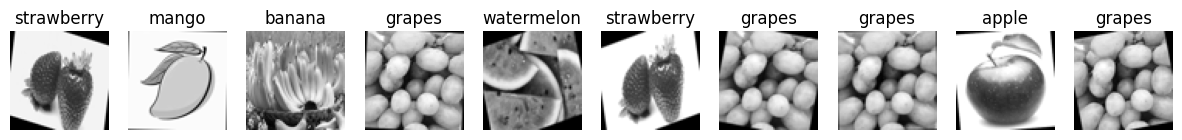

Testing Images:


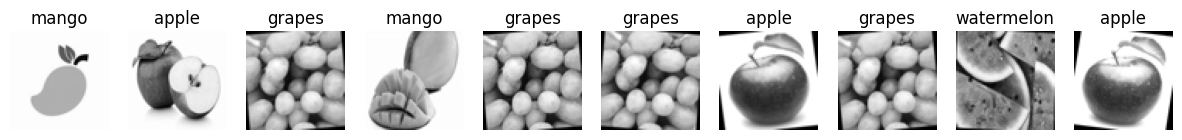

In [7]:
print("Training Images:")
visualize_data(X_train, y_train)

print("Testing Images:")
visualize_data(X_test, y_test)

### Applying PCA


In [8]:
def apply_pca(data, alpha=0.95):
    mean = np.mean(data, axis=0)
    centered_data = data - mean

    cov_matrix = np.dot(centered_data.T, centered_data) / (centered_data.shape[0] - 1)
    eig_values, eig_vectors = np.linalg.eigh(cov_matrix)

    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:, idx]

    evr = eig_values / np.sum(eig_values)
    cvr = np.cumsum(evr)
    k = np.argmax(cvr >= alpha) + 1

    print(f"Using {k} components to retain {cvr[k-1]*100:.2f}% of the variance")
    reduced_data = np.dot(centered_data, eig_vectors[:, :k])
    return reduced_data, eig_vectors, k

transformed_x_train, eig_vectors_pca_train, k = apply_pca(X_train, alpha=0.85)
centered_x_test = X_test - np.mean(X_train, axis=0)
transformed_x_test = np.dot(centered_x_test, eig_vectors_pca_train[:, :k])


Using 11 components to retain 85.41% of the variance


### Visualizing PCA Analyzed Images


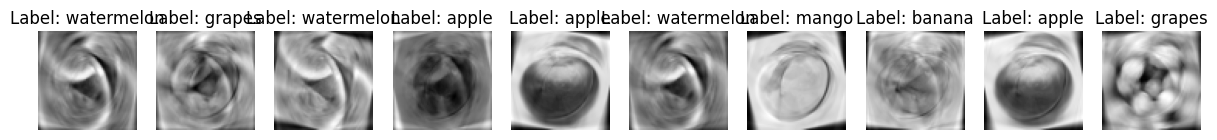

In [9]:
def pca_analyzed_images(data, eig_vectors, or_data, or_labels, or_shape=(64, 64), num_images=10):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        reconstructed_image = np.dot(data[i], eig_vectors[:, :data.shape[1]].T) + np.mean(or_data, axis=0)
        pca_analyzed_image = reconstructed_image.reshape(or_shape)

        axs[i].imshow(pca_analyzed_image, cmap='gray')
        axs[i].set_title(f"Label: {or_labels[i]}")
        axs[i].axis('off')
    plt.show()

pca_analyzed_images(transformed_x_train, eig_vectors_pca_train, X_train, y_train)


### Classifiers


In [10]:
svm = SVC()
knn = KNeighborsClassifier()
NB = GaussianNB()

### Training and Evaluating Classifiers



Results with no dimensionality reduction:
SVM Results:
Accuracy: 0.9333333333333333
Precision: 0.9345803056046468
F1 Score: 0.9334668121459443


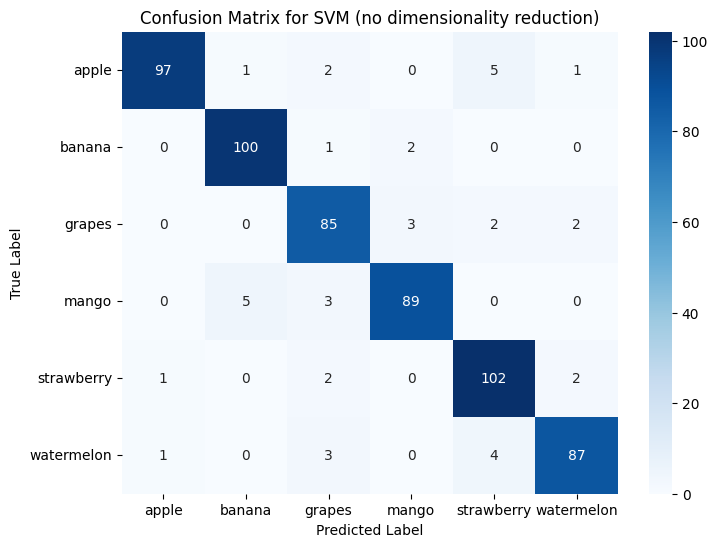


Results with no dimensionality reduction:
KNN Results:
Accuracy: 0.925
Precision: 0.9271305715297345
F1 Score: 0.9251303760940508


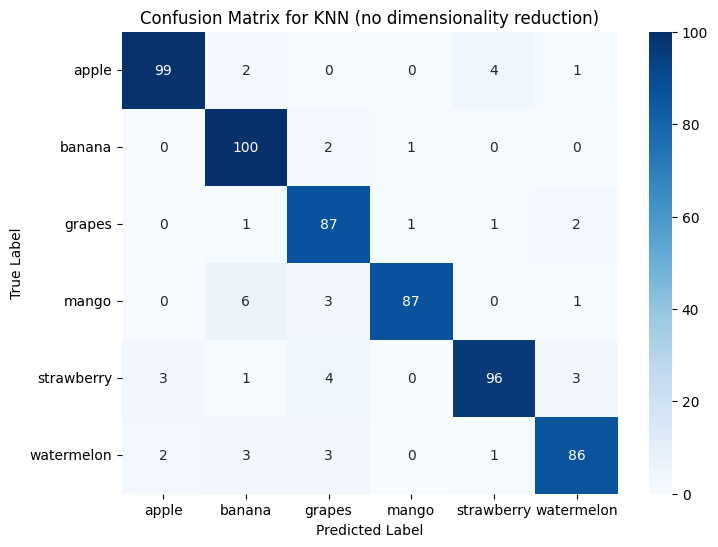


Results with no dimensionality reduction:
Naive Bayes Results:
Accuracy: 0.9083333333333333
Precision: 0.9128414377068321
F1 Score: 0.9091694284664726


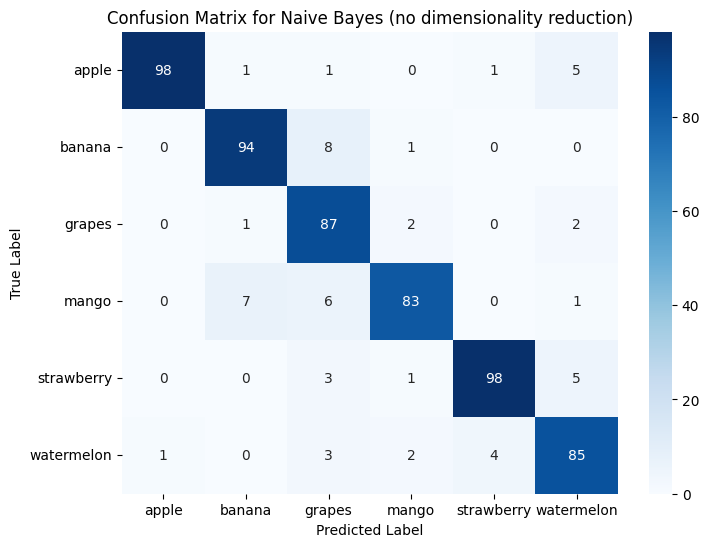


Results with after applying PCA:
SVM Results:
Accuracy: 0.93
Precision: 0.9310616593661775
F1 Score: 0.929842382272912


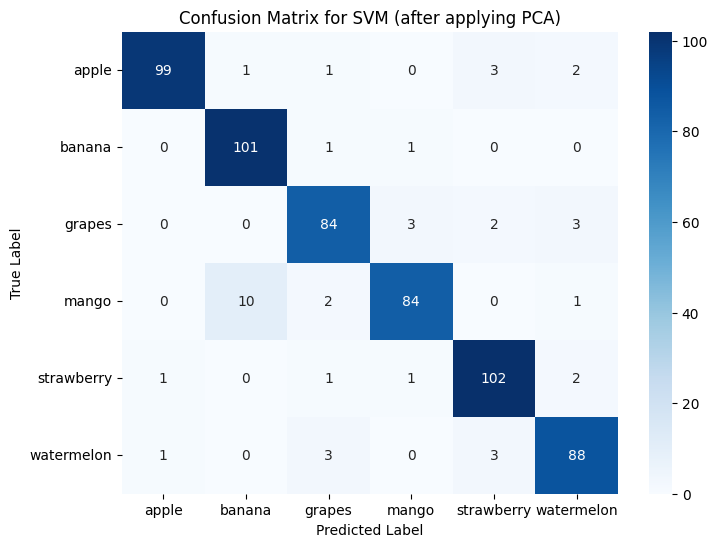


Results with after applying PCA:
KNN Results:
Accuracy: 0.9216666666666666
Precision: 0.9239046077799109
F1 Score: 0.9215123749248945


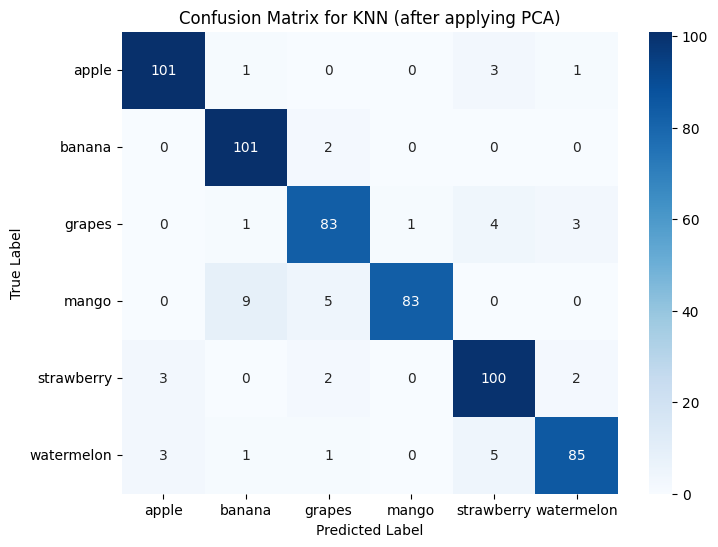


Results with after applying PCA:
Naive Bayes Results:
Accuracy: 0.9083333333333333
Precision: 0.9098967585817723
F1 Score: 0.9082026048092224


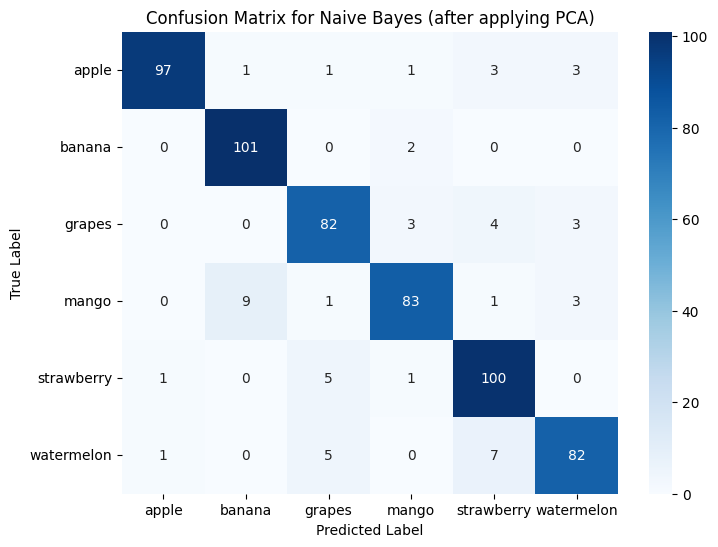

In [12]:
# Markdown: Training and Evaluating Classifiers
def evaluate(clf, train_data, train_labels, test_data, test_labels):
    clf.fit(train_data, train_labels)
    preds = clf.predict(test_data)
    acc = accuracy_score(test_labels, preds)
    prec = precision_score(test_labels, preds, average='weighted')
    f1 = f1_score(test_labels, preds, average='weighted')
    cm = confusion_matrix(test_labels, preds)
    return acc, prec, f1, cm

classifiers = {
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

def train_and_evaluate_classifiers(classifiers, train_data, train_labels, test_data, test_labels, data_representation):
    results = {}
    for name, clf in classifiers.items():
        clf.fit(train_data, train_labels)
        acc, prec, f1, cm = evaluate(clf, train_data, train_labels, test_data, test_labels)
        results[name] = {
            "Accuracy": acc,
            "Precision": prec,
            "F1 Score": f1
        }
        print(f"\nResults with {data_representation}:")
        print(f"{name} Results:")
        print("Accuracy:", acc)
        print("Precision:", prec)
        print("F1 Score:", f1)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(train_labels), yticklabels=np.unique(train_labels))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix for {name} ({data_representation})')
        plt.show()
    return results

results_before_reduction = train_and_evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test, "no dimensionality reduction")
results_after_pca = train_and_evaluate_classifiers(classifiers, transformed_x_train, y_train, transformed_x_test, y_test, "after applying PCA")